# COGS 108: Hackathon Submission #
## Crime n' Booze: Unstoppable? ##
### Jairo Chavez, Jenny Hamer, Aparna Rangamani ###

### Our question ###
What is the correlation between the crime rates and alcohol availability (evaluated by current ABC licenses) in San Diego County? Is there a relationship between the rates of particular crimes (ie. drug/alcohol violations, theft/larceny, DUI, vandalism, sex crimes, etc) and the number of establishments holding ABC licenses in the community/district?

In [1]:
% reset
% config InlineBackend.figure_format = 'retina'
% matplotlib inline

# our imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import patsy

from scipy import stats
import statsmodels.api as sm
from scipy.stats import ttest_ind
from matplotlib import rcParams

import geocoder
import folium
from haversine import haversine

rcParams['figure.figsize'] = [15, 15]
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
sns.set(style='whitegrid', context ='paper')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


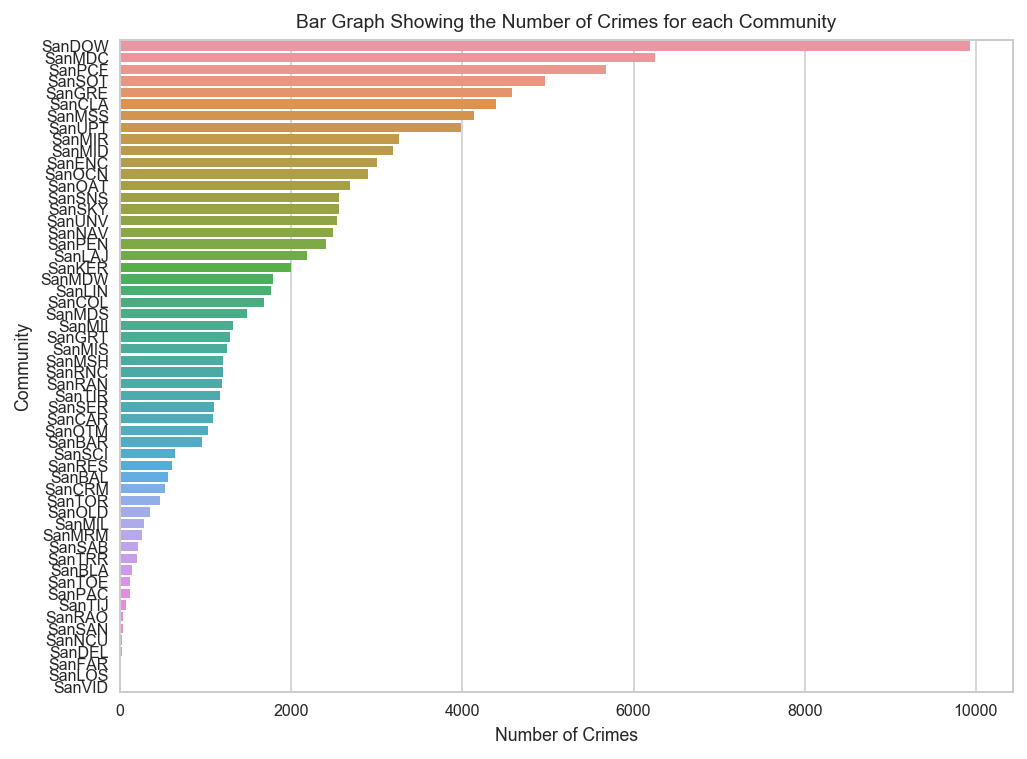

In [2]:
# import our incidents-100k dataset into a DataFrame
df = pd.read_csv("incidents-100k.csv")

# first remove any rows where the community is specified by NONE
# DATA CLEANING: remove rows that do not have a community specified, or community population
# print(df.shape)
df = df[df['community'] != 'NONE']
# print(df.shape)
df = df[df['comm_pop'] != 0]
# print(df.shape)

# get the community populations and plot as a bar graph to check normalization 
counts_by_community = df['community'].value_counts()
counts_by_pops = df['comm_pop'].value_counts()

comm_dict = counts_by_community.to_dict()
# print(comm_dict)

pops_dict = counts_by_pops.to_dict()
# print(pops_dict)

# plotting in seaborn
# seaborn.countplot(x='community', data=comm_pops)
dims = (8, 6)
fig, ax = plt.subplots(figsize=dims)
axes = sns.barplot(ax=ax, x=counts_by_community, y=counts_by_community.index)
axes.set(xlabel='Number of Crimes', ylabel='Community', title='Bar Graph Showing the Number of Crimes for each Community')
sns.plt.show()

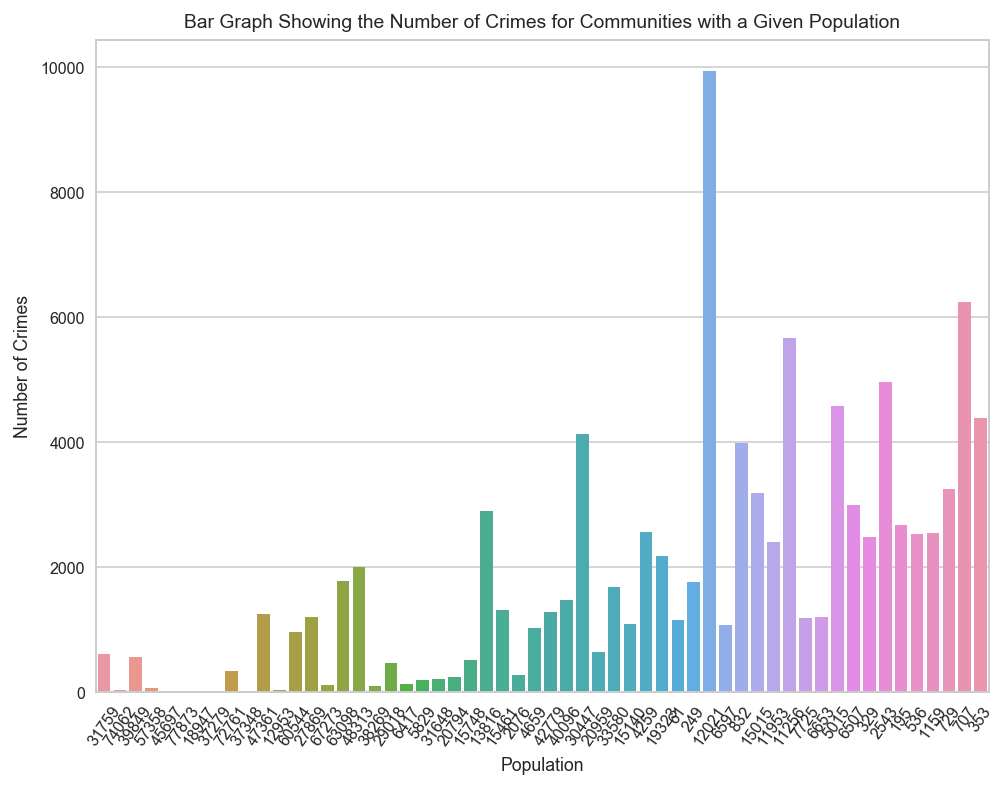

In [3]:
# bar plot of the number of crimes by population
dims = (8, 6)
fig, ax = plt.subplots(figsize=dims)
bargraph = sns.barplot(x=counts_by_pops.index, y=counts_by_pops)
bargraph.set_xticklabels(labels=counts_by_pops.index, rotation=55)
bargraph.set(xlabel="Population", ylabel="Number of Crimes", title="Bar Graph Showing the Number of Crimes for Communities with a Given Population")
sns.plt.show()

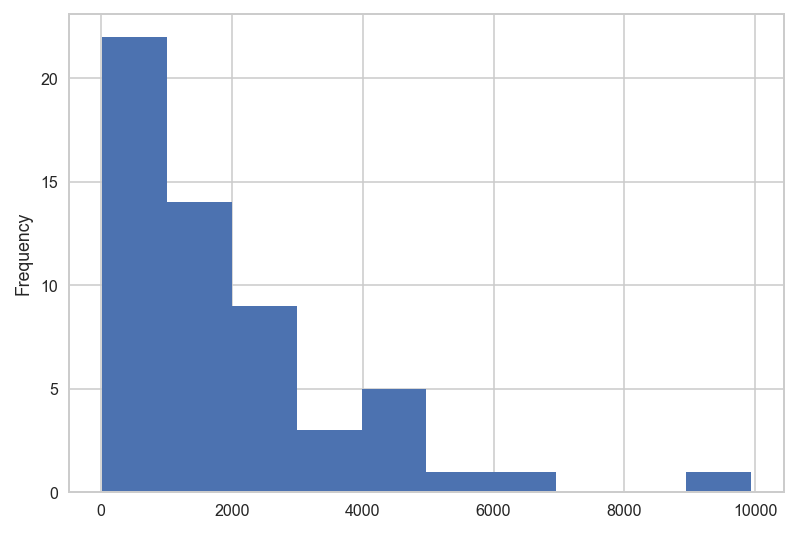

In [4]:
# plot of incident counts by community population (histogram)
counts_by_community.plot(kind="hist")
f2 = plt.show()
f2 = plt.gcf()

In [5]:
# Data Cleaning! dictionary of Clarinova Place Codes to Full names
cpc_to_fullname = {'SanBAL':'Balboa Park', ' SanBAR':'Barrio Logan',
                    'SanBLA':'Black Mountain Ranch', 'SanCAR':'Carmel Valley',
                    'SanCLA':'Clairemont Mesa', 'SanCOL':'College Area',
                    'SanCRM':'Carmel Mountain Ranch', 'SanDEL':'Del Mar Mesa',
                    'SanDOW':'Downtown', 'SanENC':'Encanto Neighborhoods, Southeastern',
                    'SanEST':'East Elliott', 'SanFAR':'Fairbanks Ranch Country Club',
                    'SanGRE':'Greater North Park', 'SanGRT':'Greater Golden Hill',
                    'SanKER':'Kearny Mesa', 'SanLAJ':'La Jolla', 'SanLIN':'Linda Vista',
                    'SanLOS':'Los Penasquitos Canyon', 'SanMDC':'Mid-City:City Heights',
                    'SanMDS':'Mid-City:Normal Heights', 'SanMDW':'Midway-Pacific Highway',
                    'SanMID':'Mid-City:Eastern Area', 'SanMII':'Mid-City:Kensington-Talmadge',
                    'SanMIL':'Military Facilities', 'SanMIR':'Mira Mesa',
                    'SanMIS':'Mission Bay Park', 'SanMRM':'Miramar Ranch North',
                    'SanMSH':'Mission Beach', 'SanMSS':'Mission Valley',
                    'SanNAV':'Navajo', 'SanNCU':'Ncfua Subarea Ii', 'SanOAT':'Otay Mesa-Nestor',
                    'SanOCN':'Ocean Beach', 'SanOLD':'Old Town San Diego', 'SanOTM':'Otay Mesa',
                    'SanPAC':'Pacific Highlands Ranch', 'SanPCF':'Pacific Beach',
                    'SanPEN':'Peninsula', 'SanRAN':'Rancho Bernardo',
                    'SanRAO':'Rancho Encantada','SanRES':'Reserve', 'SanRNC':'Rancho Penasquitos',
                    'SanSAB':'Sabre Springs', 'SanSAN':'San Pasqual', 'SanSCI':'Scripps Miramar Ranch',
                    'SanSER':'Serra Mesa', 'SanSKY':'Skyline-Paradise Hills', 
                    'SanSNS':'San Ysidro', 'SanSOT':'Southeastern San Diego, Southeastern',
                    'SanTIJ':'Tijuana River Valley', 'SanTIR':'Tierrasanta',
                    'SanTOE':'Torrey Hills', 'SanTOR':'Torrey Pines', 
                    'SanTRR':'Torrey Highlands', 'SanUNV':'University', 
                    'SanUPT':'Uptown', 'SanVID':'Via De La Valle'}

In [6]:
# determine the population rate per city and save in a new dataframe df_stats
df_stats = df[['community','comm_pop']].drop_duplicates()

# add a column 'crime' to df_stats that represents the raw count of crimes for that community 
# (raw counts are determined by the number of rows containing the community )
df_stats['crime'] = df.groupby('community')['community'].transform('count')

# add a column 'crimerate' to df_stats to normalize for the population
df_stats['crimerate'] = df_stats['crime'] / df_stats['comm_pop']

#use data from df_stats to get a dictionary where the keys are the community names and the values are the crime rates
dict_crimerate = df_stats[['community', 'crimerate']].set_index('community')['crimerate'].to_dict()

# print(df_stats)
# print(dict_crimerate)

# remove outlier: community with lower population than crime
df_stats = df_stats[df_stats['comm_pop'] > df_stats['crime']]
# print(df_stats)

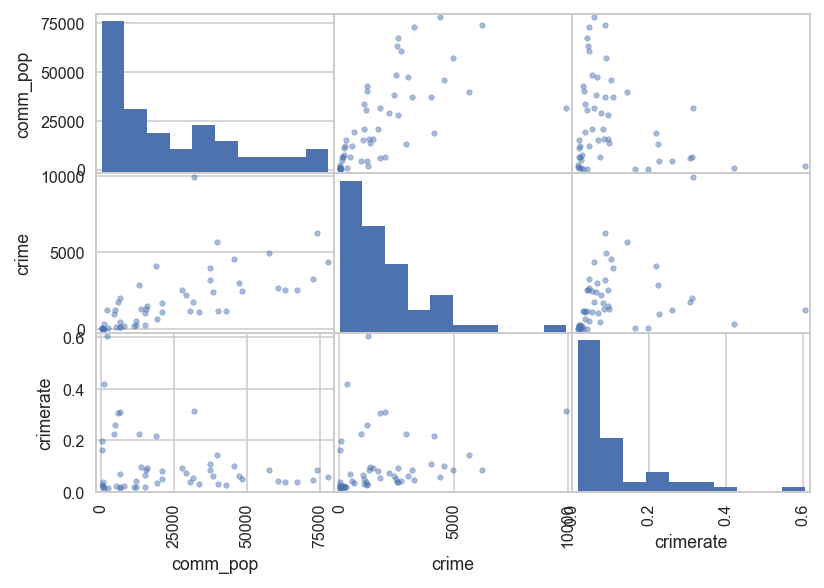

In [7]:
# plot a scatter matrix of the crime ratios 
fig = pd.scatter_matrix(df_stats)

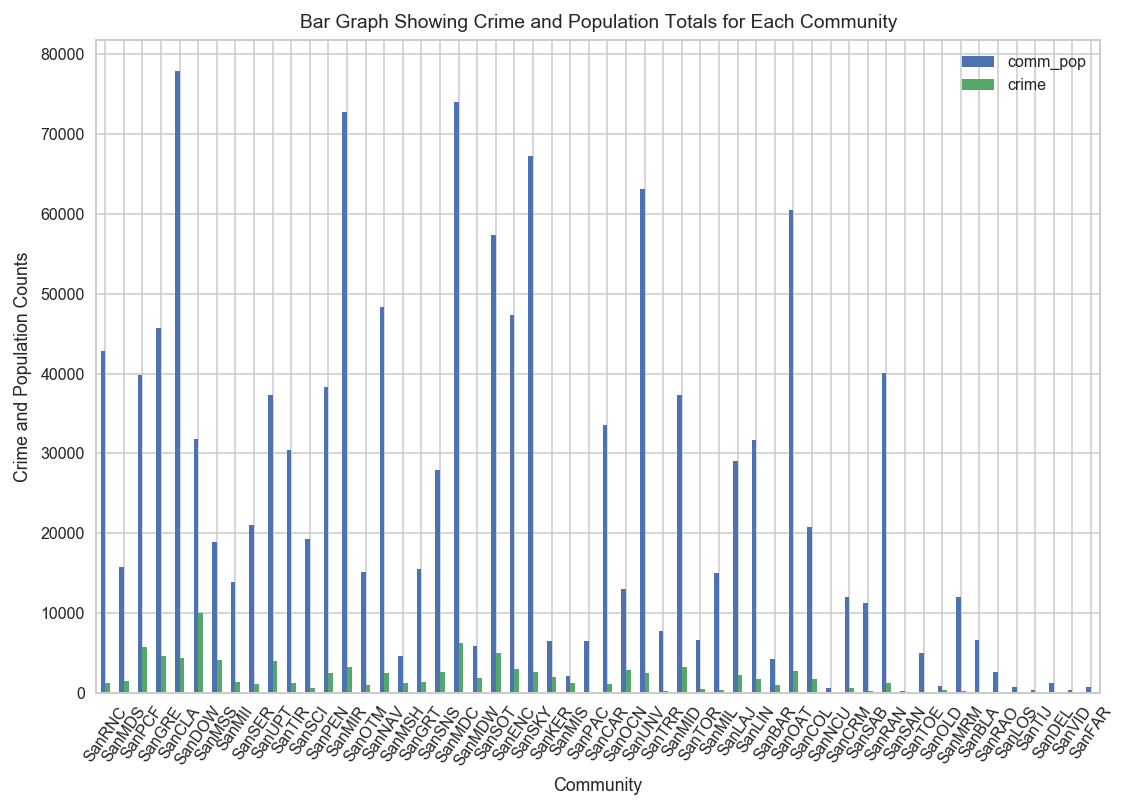

In [8]:
# plot the total crime and population counts per community
axes = df_stats[['community', 'comm_pop', 'crime']].plot.bar(figsize=(9,6))
axes.set_xticklabels(labels=df_stats.community, rotation=55)
axes.set(xlabel="Community", ylabel="Crime and Population Counts", title="Bar Graph Showing Crime and Population Totals for Each Community")

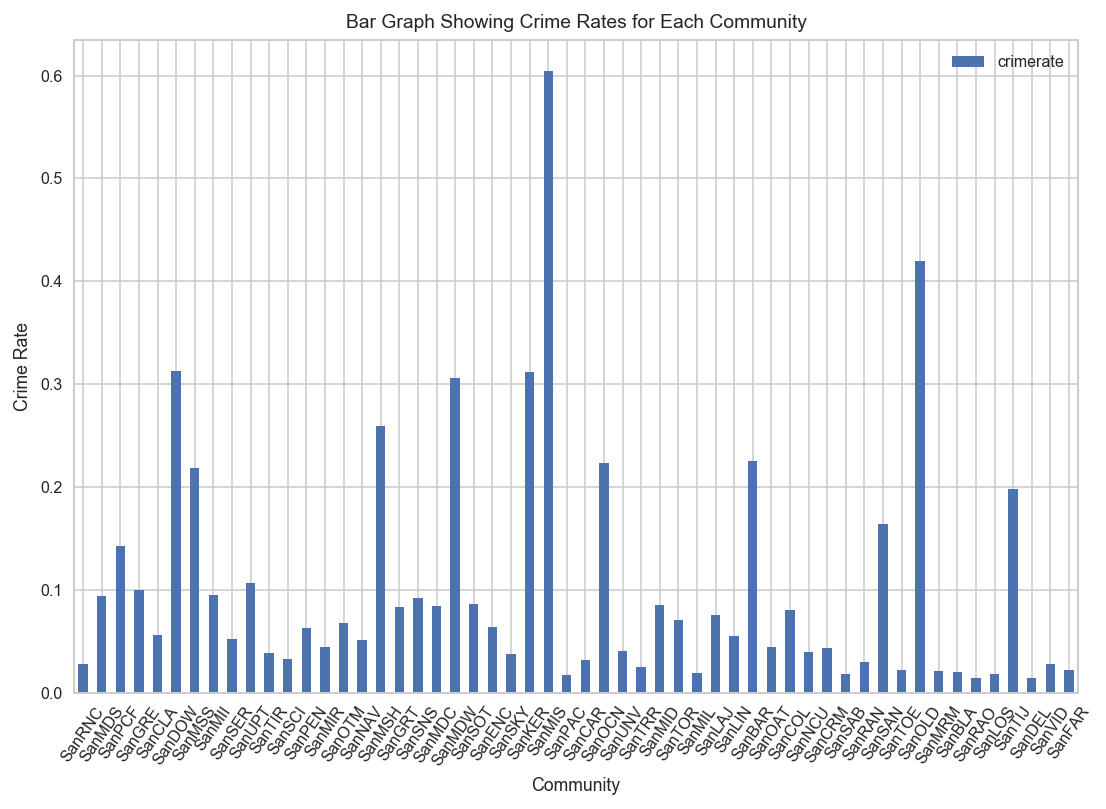

In [9]:
# plot the crime rate (ratio of total number of crimes to total population) 
# per city
axes = df_stats[['community', 'crimerate']].plot.bar(figsize=(9,6))
axes.set_xticklabels(labels=df_stats.community, rotation=55)
axes.set(xlabel="Community", ylabel="Crime Rate", title="Bar Graph Showing Crime Rates for Each Community")


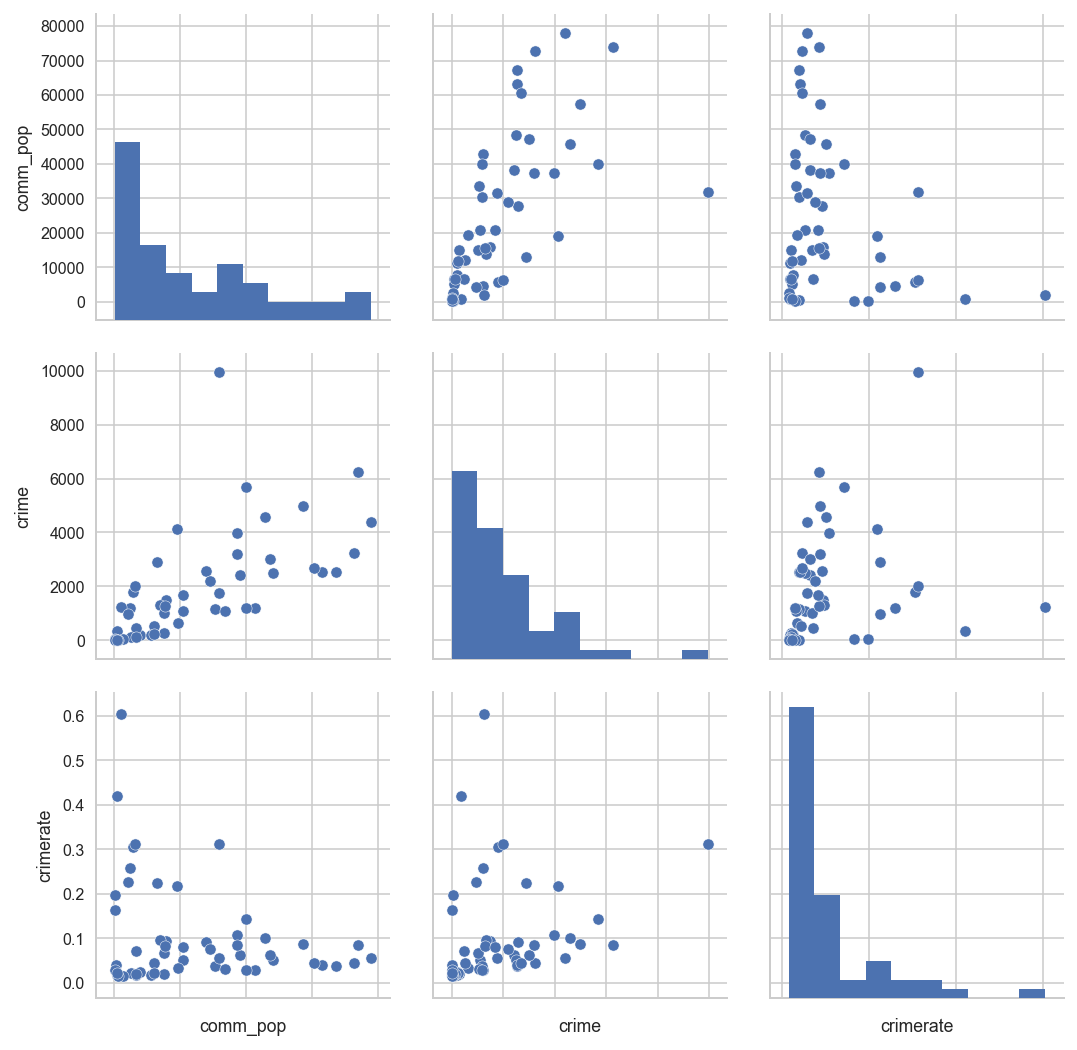

In [10]:
# histogram plot of population to number of crime incidents
pairplots = sns.pairplot(df_stats)
pairplots.set(xticklabels=[])

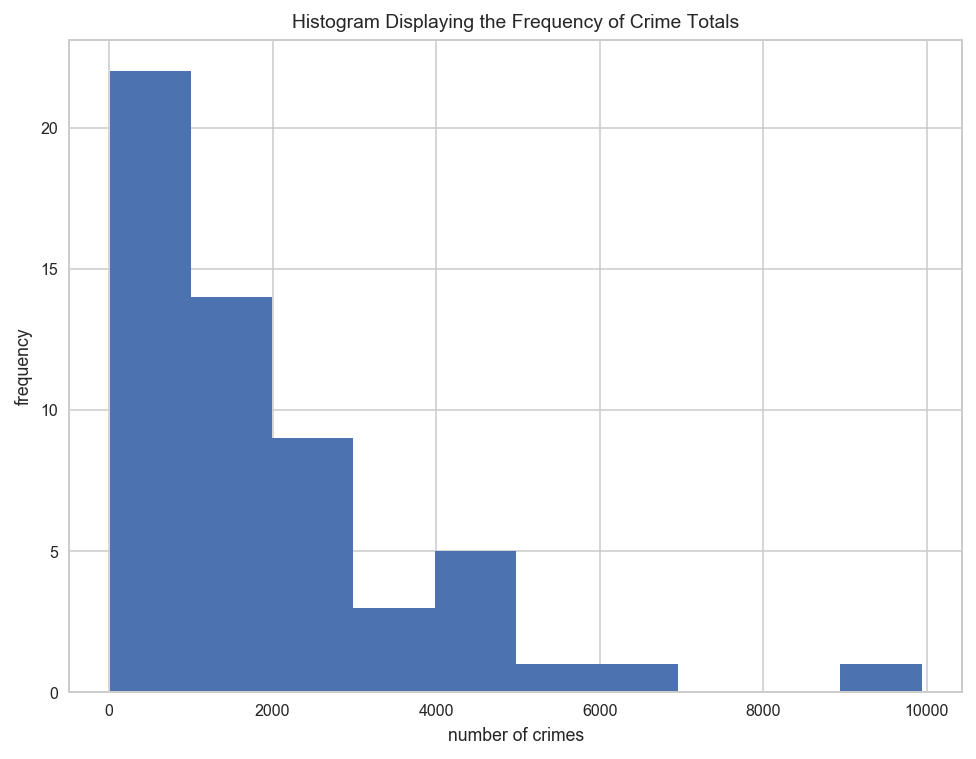

In [11]:
# plot of incident counts by community (histogram)
axes = counts_by_community.plot(kind="hist", figsize = (8,6))
axes.set(xlabel="number of crimes", ylabel="frequency", title="Histogram Displaying the Frequency of Crime Totals")
f2 = plt.show()
f2 = plt.gcf()

,comm_pop,crime,crimerate
comm_pop,1.000000,0.653189,-0.248275
crime,0.653189,1.000000,0.227748
crimerate,-0.248275,0.227748,1.000000


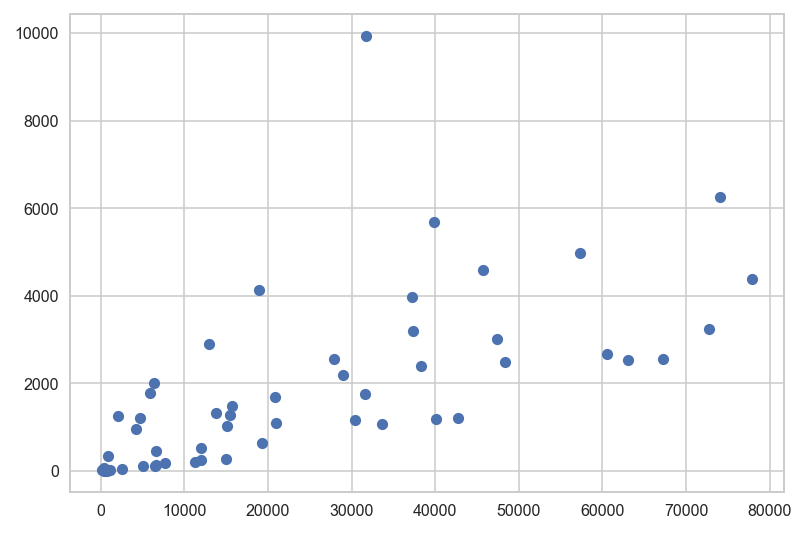

In [12]:
# plot the community populations to respective crime incidents counts
x = df_stats['comm_pop']
y = df_stats['crime']
plt.plot(x, y, "o")
df_stats.corr()

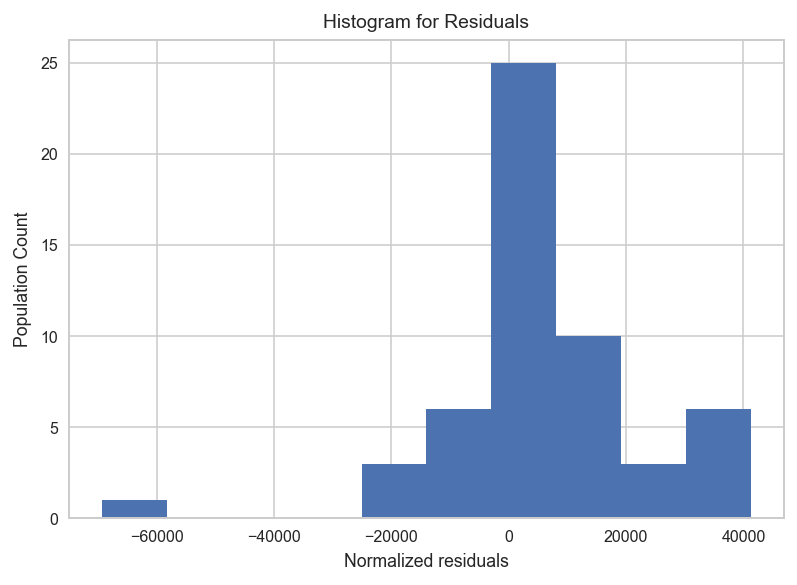

In [13]:
# checking the distribution/normality of the residuals
model = sm.OLS(x, y)
fit_to_get_residuals = model.fit()

# histogram of the normalized residuals: how's our distribution?
plt.hist(fit_to_get_residuals.resid)
plt.ylabel('Population Count')
plt.xlabel('Normalized residuals')
plt.title('Histogram for Residuals')

0.0571299696035 450.631078322 0.653188872092 8.61762192161e-08 0.0091839876795


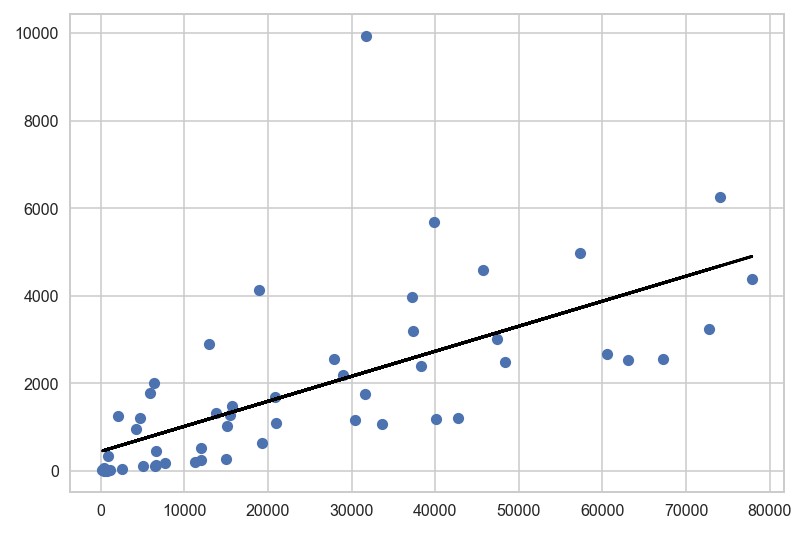

In [14]:
# fit the linear regression for crime to community population
slope, intercept, corr_value, p_value, std_err = stats.linregress(x,y)

predicted_y = intercept + slope * x
predicted_error = y - predicted_y
degr_freedom = len(x) - 2
residual_std_error = np.sqrt(np.sum(predicted_error ** 2) / degr_freedom)

# display the slope, intercept, correlation coefficient, p value, and standard error
print(slope, intercept, corr_value, p_value, std_err)

# plotting linear regression/least squares 
plt.plot(x, y, 'o')
plt.plot(x, predicted_y, 'k-')
plt.show()

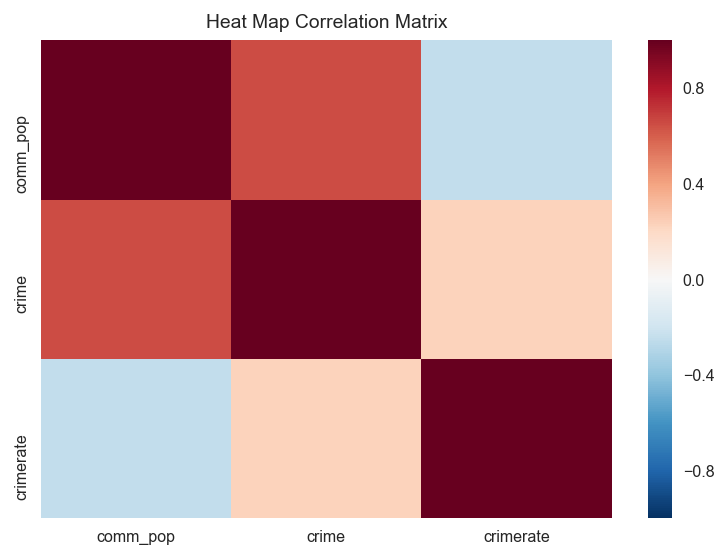

In [15]:
# correlation matrix of crime to population by community
crime_corr = df_stats.corr()
crime_heatmap = sns.heatmap(crime_corr, 
            xticklabels=crime_corr.columns.values,
            yticklabels=crime_corr.columns.values)
crime_heatmap.set(title='Heat Map Correlation Matrix')

In [16]:
# 2012 length --> 143182 for incidents 57
# 2012 length --> 13923 for incidents-100k.csv
df_2012=df.loc[df['year']== 2012]
j=0
points = []
for i in range (100):
    latitude = df['lat'][j]
    longitude = df['lon'][j]
    points.append(tuple([latitude,longitude]))
    j=j+1

In [17]:
csv_file = 'abc_licenses_sdcounty.csv'
df2 = pd.read_csv(csv_file)

In [18]:
points2 = []
j=0
df_alcohol = pd.read_csv('abc_licenses_sdcounty.csv')
df_alcohol = df_alcohol.loc[(df_alcohol["premisesaddress"].str.contains(', SAN DIEGO, CA'))] 

for j, row in df_alcohol.iterrows():
    latitude = row['lat']
    longitude = row['lon']
    points2.append(tuple([latitude,longitude]))
    

In [19]:
df_Clairemont = df.loc[df['community']=='SanCLA']
#df_San_Clemente --> 4388 rows × 26 columns

df_Encanto = df.loc[df['community']=='SanENC']
#df_Encinitas --> 3006 rows × 26 columns

df_Clairemont['comm_pop'].value_counts()

77873    4388
Name: comm_pop, dtype: int64

In [20]:
San_CLA_Popu = df_Clairemont['comm_pop'].value_counts()


zip_dict = {}
zip_length = len(San_CLA_Popu)
i=0
count = 0
total_population = 0
diff_populations = 0
for i in df_Clairemont.index:
    get_CLA_popu=df_Clairemont.ix[i, 'comm_pop'] 
    if get_CLA_popu in zip_dict:
        count = (zip_dict.get(get_CLA_popu))+1
        zip_dict.update({get_CLA_popu:count})
    else:
        count = 0
        zip_dict.update({get_CLA_popu:1})
        
for x,y in zip_dict.items():
    total_population = total_population+x
    if x!=0:
        diff_populations +=1
    

final_population = (total_population // diff_populations)
final_population

77873

In [21]:
Clairemont_population = final_population

In [22]:
Encanto_Popu = df_Encanto['comm_pop'].value_counts()


zip_dict2 = {}
zip_length = len(Encanto_Popu)
i=0
count = 0
total_population = 0
diff_populations = 0
for i in df_Encanto.index:
    get_Encanto_popu=df_Encanto.ix[i, 'comm_pop'] 
    if get_Encanto_popu in zip_dict2:
        count = (zip_dict2.get(get_Encanto_popu))+1
        zip_dict2.update({get_Encanto_popu:count})
    else:
        count = 0
        zip_dict2.update({get_Encanto_popu:1})
        
for x,y in zip_dict2.items():
    total_population = total_population+x
    if x!=0:
        diff_populations +=1
    

final_population = (total_population // diff_populations) 

#final_population

In [23]:
Encanto_population = final_population

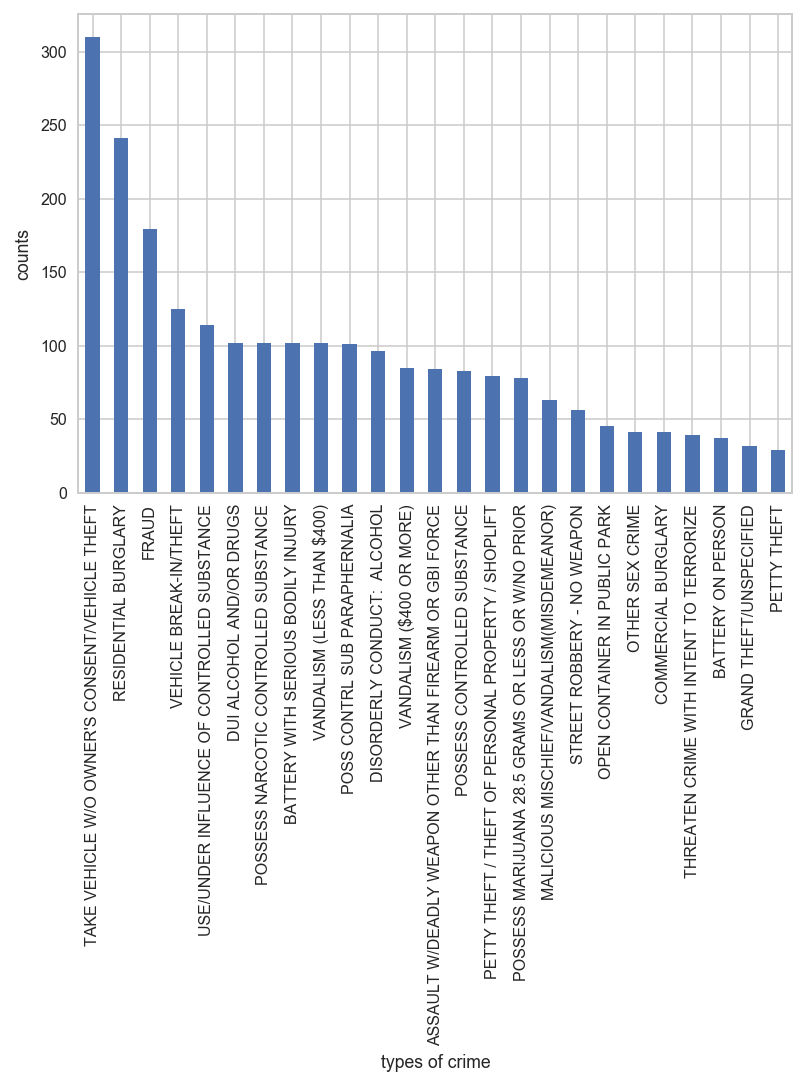

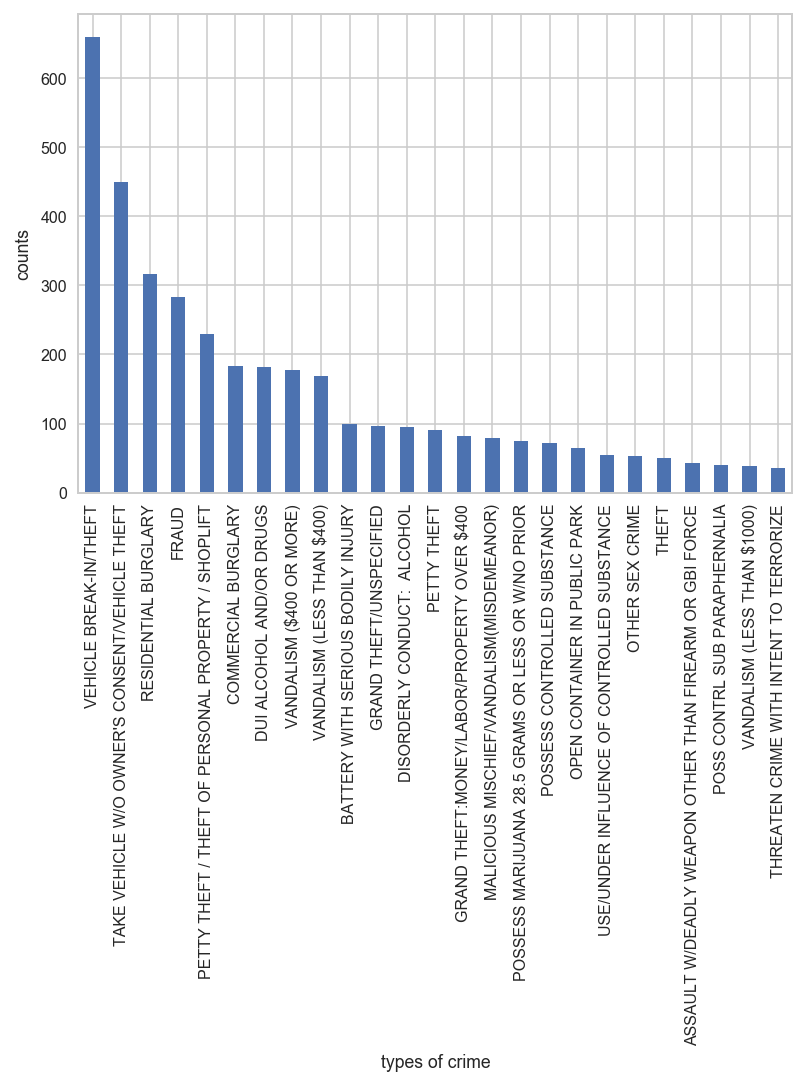

In [24]:
diff_crime_Encanto = df_Encanto['desc'].value_counts()[0:25]
diff_crime_Encanto.plot.bar()
plt.ylabel('counts')
plt.xlabel('types of crime')
plt.show()

diff_crime_Clairemont = df_Clairemont['desc'].value_counts()[0:25]
diff_crime_Clairemont.plot.bar()
plt.ylabel('counts')
plt.xlabel('types of crime')
plt.show()

In [25]:
# read in the dbf (metadata) file and list all the methods associated with it
import shapefile
sf = shapefile.Reader("ZillowNeighborhoods-CA.dbf")

In [26]:
metadata = sf.shapeRecords()
metadata[38].record

['CA', 'San Diego', 'San Diego', 'Ocean Beach', '117021']

In [27]:
# find indices of all San Diego neighborhoods
sd_list = []
counter = 0

for i in range(len(metadata)):
    if metadata[i].record[2] == 'San Diego':
        sd_list.append(i)
        counter += 1


In [28]:
shapes = sf.shapes()

sd_shapes = []

for i in range(len(sd_list)):
    sd_shapes.append(shapes[sd_list[i]].points)

for i in range(len(sd_shapes)):
    for j in range(len(sd_shapes[i])):
        sd_shapes[i][j] = sd_shapes[i][j][::-1]


In [29]:
read_shapemeta=shapefile.Reader('ZillowNeighborhoods-CA.dbf')
shapemeta = read_shapemeta.shapeRecords()


sorted_SD_list = []


# This prints out the communities in san diego
for i in range(len(shapemeta)):
     if metadata[i].record[2] == 'San Diego':
        sorted_SD_list.append(shapemeta[i].record[3])


In [30]:
for i in range(len(shapemeta)):
     if metadata[i].record[2] == 'San Diego':
        sorted_SD_list.append(shapemeta[i].record[1])
#sorted_SD_list

In [31]:
# determine the population rate per city and save in a new dataframe df_stats
df_stats = df[['community','comm_pop']].drop_duplicates()

# add a column 'crime' to df_stats that represents the raw count of crimes for that community 
# (raw counts are determined by the number of rows containing the community )
df_stats['crime'] = df.groupby('community')['community'].transform('count')

# add a column 'crimerate' to df_stats to normalize for the population
df_stats['crimerate'] = df_stats['crime'] / df_stats['comm_pop']

#use data from df_stats to get a dictionary where the keys are the community names and the values are the crime rates
dict_crimerate = df_stats[['community', 'crimerate']].set_index('community')['crimerate'].to_dict()

# print(df_stats)
# print(dict_crimerate)

# remove outlier: community with lower population than crime
df_stats = df_stats[df_stats['comm_pop'] > df_stats['crime']]

max_ratio = (max(df_stats['crimerate']))
min_ratio = (min(df_stats['crimerate']))

one_fifth = (max_ratio/5)
print(one_fifth*5, max_ratio)

sorted_df_stats = sorted(df_stats['crimerate'])
#print(np.mean(df_stats['crimerate']))

0.604046242775 0.604046242775


In [32]:
j=0
lat=32.7157
lon=-117.1611
zoom_start=11
m = folium.Map(location=[lat, lon], zoom_start=zoom_start,tiles='Stamen Toner')
if (len(points)<(len(points2))):
    length=(len(points))
else:
    length=(len(points2))
for i in range(length):
    #coord_1 = points[j]
    coord_2 = points2[j]
    #kw = dict(fill_color='red', radius=5)
    kw2 = dict(fill_color='black' ,radius=4)
    #c0 = folium.CircleMarker(coord_1, **kw)
    c1 = folium.CircleMarker(coord_2, **kw2)
    for c in [c1]:
        m.add_child(c)
    j=j+1

    
    
j=0
df_stats_length = len(df_stats)
for c in range(len(sd_shapes)):
    
    #for i in range (len(sorted_df_stats)):
    #print((sorted_df_stats[j]*100))
    
    
    
    
    if c <=(sorted_df_stats[10]*100):
        colour = '#f0f9e8'        #Transparent color
    if c >(sorted_df_stats[10]*100) and c<=(sorted_df_stats[20]*100):
        colour = '#bae4bc'         # green color
    if c >(sorted_df_stats[20]*100) and c<=(sorted_df_stats[30]*100):
        colour = '#7bccc4'          # Cyan color
    if c >(sorted_df_stats[30]*100) and c<=(sorted_df_stats[40]*100):
        colour = '#43a2ca'           # Blue color
    if c >(sorted_df_stats[40]*100) and c<=(sorted_df_stats[df_stats_length-1]*100):
        colour = '#0868ac'           # Dark blue
    if c>(df_stats_length) and c<=(len(sd_shapes)):
        colour = 'white'

    j=j+1
    hood_line = folium.features.PolygonMarker(locations=sd_shapes[c], color='pink', fill_color=colour, weight=3)
    m.add_child(hood_line)
    #if (j==(df_stats_length)):
    #    m
    #    break
m

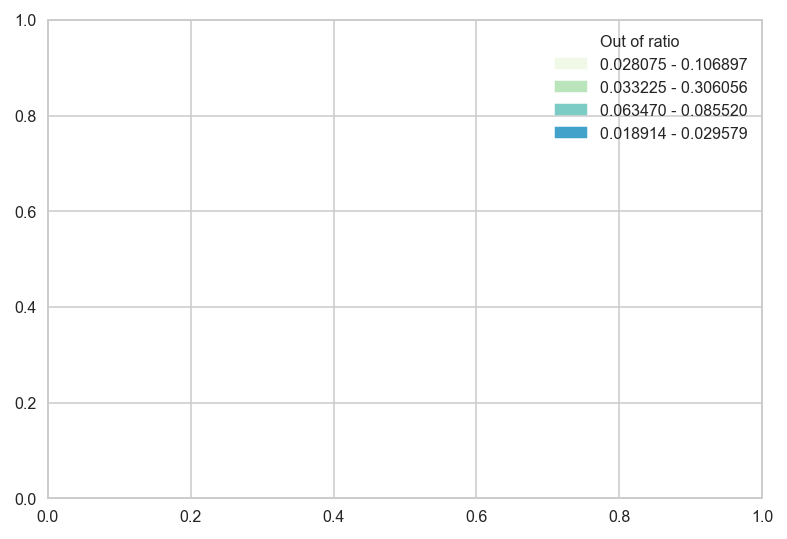

In [33]:
import matplotlib.patches as mpatches

colour_1 = mpatches.Patch(color = 'white', label = 'Out of ratio')
colour_2 = mpatches.Patch(color='#f0f9e8', label='0.028075 - 0.106897')
colour_3 = mpatches.Patch(color='#bae4bc', label='0.033225 - 0.306056')
colour_4 = mpatches.Patch(color='#7bccc4', label='0.063470 - 0.085520')
colour_5 = mpatches.Patch(color='#43a2ca', label='0.018914 - 0.029579')
colour_6 = mpatches.Patch(color='#0868ac', label='0.022333 - 0.021948 ')
plt.legend(handles=[colour_1,colour_2,colour_3,colour_4,colour_5])

plt.show()